# Линейный Энкодер-Декодер

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
plt.style.use('seaborn')

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
from skimage import transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from functions import *
from functions import good_cols, SignalDataset
from typing import Union 
%matplotlib inline

In [2]:
all_df = get_df()

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.10s/it]


### Выбираем длину

In [3]:
TARGET_LEN = 10000
activities = sep_by_len(all_df, TARGET_LEN)
activities.shape

(83, 32)

In [4]:
CUT_LEN = 100
cut_df = cut_act(activities, CUT_LEN, count=50, random_start=True)
cut_df.sample()

100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:11<00:00,  7.31it/s]


,activityID,heart rate,temperature hand,3Da_x scale_16 hand,3Da_y scale_16 hand,3Da_z scale_16 hand,3Dg_x hand,3Dg_y hand,3Dg_z hand,3Dm_x hand,...,temperature ankle,3Da_x scale_16 ankle,3Da_y scale_16 ankle,3Da_z scale_16 ankle,3Dg_x ankle,3Dg_y ankle,3Dg_z ankle,3Dm_x ankle,3Dm_y ankle,3Dm_z ankle
3923,12,"[120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120...","[34.3125, 34.3125, 34.3125, 34.3125, 34.3125, ...","[-13.3366, -13.9453, -14.5012, -15.0015, -15.0...","[-0.564673, -0.750371, -0.516011, -0.665987, -...","[0.0731511, -0.0123141, 0.24798, 0.0100672, -0...","[-0.263018, 0.218673, 0.794952, 1.26126, 1.649...","[3.24489, 3.27395, 3.21824, 3.16317, 3.02002, ...","[2.97852, 3.05594, 3.12266, 3.16207, 3.09149, ...","[23.2748, 25.1497, 26.5222, 28.9119, 29.6415, ...",...,"[34.25, 34.25, 34.25, 34.25, 34.25, 34.25, 34....","[14.7917, 17.7312, 19.7234, 21.5868, 25.4828, ...","[-4.46089, 0.675587, 2.10551, -6.36849, 0.0215...","[-4.58332, -3.50455, -3.4544, -8.66947, -8.399...","[1.51788, 0.60993, -0.655141, -2.45187, -3.991...","[0.305421, 0.521992, 0.889844, 1.02335, 0.6872...","[0.193194, 1.08062, 1.99924, 2.85991, 3.46163,...","[-30.011, -30.6793, -30.1734, -29.257, -29.111...","[23.0946, 24.6737, 25.0355, 24.0894, 23.9576, ...","[41.4144, 41.6939, 41.9789, 42.2669, 43.6859, ..."


### Получаем признаки

In [94]:
X = cut_df.iloc[:, 1:].values

Y = cut_df.iloc[:, 0] # целевая переменная
X.shape, Y.shape

((4150, 31), (4150,))

In [95]:
y_targ = y_encode(Y)
np.unique(y_targ)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

### Нормализация

In [96]:
X_norm = normalize_dif_len(X)
X_norm.shape

(100, 4150, 31)

### Приводим к одной длине

In [97]:
X_eq = np.transpose(np.array(X_norm,dtype=np.float64), axes = [1,0,2])
X_eq.shape

(4150, 100, 31)

In [98]:
X_flat = get_flatten(X_eq)
X_flat.shape

(4150, 3100)

In [99]:
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = \
    train_test_split(torch.FloatTensor(X_flat), torch.LongTensor(y_targ), random_state=42, test_size = 0.2)
X_train_tensor.shape, y_train_tensor.shape, np.unique(y_train_tensor), np.unique(y_val_tensor)

(torch.Size([3320, 3100]),
 torch.Size([3320]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64))

In [100]:
BATCH_SIZE = 64

trainset = SignalDataset(X_train_tensor, y_train_tensor)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

testset = SignalDataset(X_val_tensor, y_val_tensor)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)
len(trainset)

3320

## Подготовка модели

In [101]:
torch.min(X_train_tensor), torch.max(X_train_tensor)

(tensor(-39.1376), tensor(74.4165))

In [102]:
activation = nn.LeakyReLU

class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 4096),
            activation(),
            nn.Linear(4096, 512),
            activation(),
            nn.Linear(512, 128),
            activation(),
            nn.Linear(128, 32),
            activation(),
            nn.Linear(32, 4),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(4, 32),
            activation(),
            nn.Linear(32, 128),
            activation(),
            nn.Linear(128, 512),
            activation(),
            nn.Linear(512, 4096),
            activation(),
            nn.Linear(4096, input_size),
            
        )
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec

net = Autoencoder(X_train_tensor.shape[1])

## Обучение

In [103]:
NUM_EPOCHS = 10

loss_fn = torch.nn.MSELoss()
losses = []
val_losses = []

learning_rate = 3e-3
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)
ebar = tqdm(range(NUM_EPOCHS))

for epoch_num in ebar:
    running_loss = 0.0
    iter_num = 0
#     pbar = tqdm(enumerate(trainloader), total = len(trainloader))
    pbar = enumerate(trainloader)
    for iter_num, (X_batch, y_batch) in pbar:
        iter_num +=1
        
        recon = net(X_batch)
        
        loss = loss_fn(recon, X_batch)
        running_loss += loss.item()
                     
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    line = '[{}/{}] current loss: {}'.format(epoch_num+1, NUM_EPOCHS, running_loss/len(trainset))
    ebar.set_description(line)
    
    losses.append(running_loss/len(trainset))
        
    with torch.no_grad():
        recon = net(X_val_tensor)
        score = loss_fn(recon, X_val_tensor)
#         line = '[{}/{}] current valid score: {}'.format(epoch_num+1, NUM_EPOCHS, f1_score(y_val_tensor, y, average='macro'))
#         print(line)
        val_losses.append(score)

[10/10] current loss: 0.008499488683350116: 100%|██████████████████████████████████████| 10/10 [02:00<00:00, 12.05s/it]


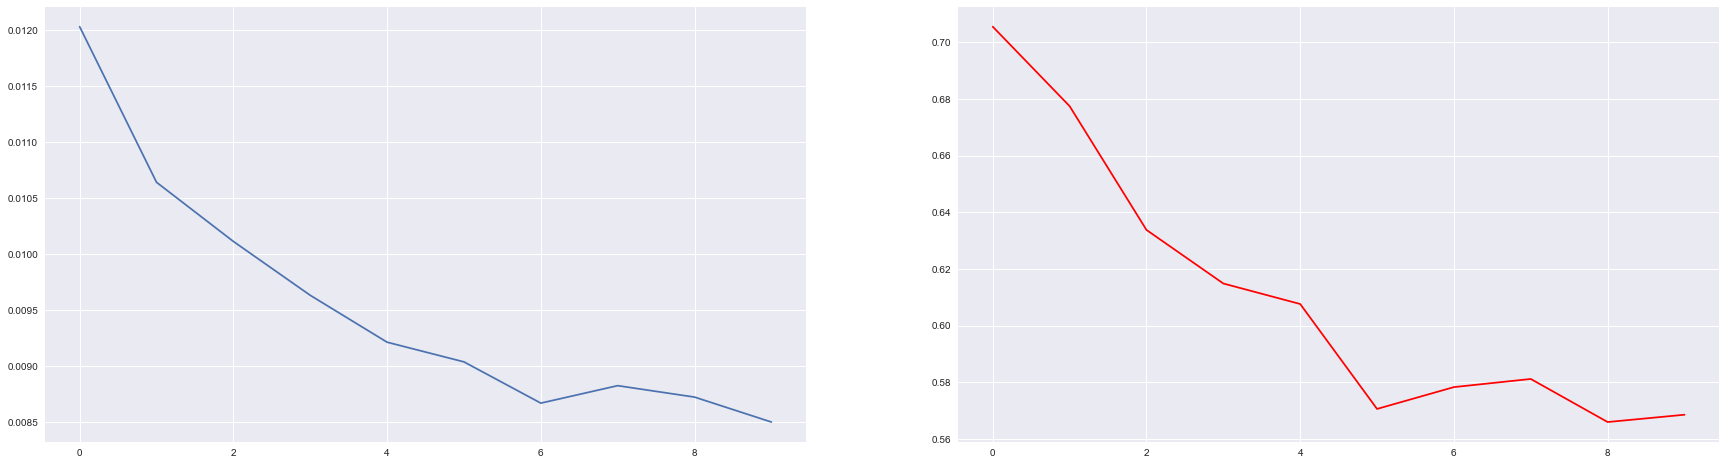

In [104]:
fig, axs = plt.subplots(1,2,figsize=(30,8))
axs[0].plot(np.arange(NUM_EPOCHS), losses)
axs[1].plot(np.arange(NUM_EPOCHS), val_losses, color='red')
plt.show()

### Оценка точности

In [91]:
recon = net(X_val_tensor)
a = np.reshape(recon.detach().numpy(),(-1, CUT_LEN, 31))
b = np.reshape(X_val_tensor.detach().numpy(),(-1, CUT_LEN, 31))

r = np.random.randint(0, len(a))
a[r, :5, :5], b[r, :5, :5], r

(array([[-0.0276061 ,  0.7536838 ,  0.1370657 ,  0.2244466 ,  0.30526933],
        [-0.14929423,  0.75693357,  0.24678905,  0.31539115,  0.34234518],
        [ 0.04000431,  0.8789592 ,  0.15777595,  0.04207595,  0.24487248],
        [ 0.16523504,  0.84577733,  0.43686298,  0.33113182,  0.39993882],
        [-0.16242136,  0.8127325 ,  0.3193886 ,  0.19105776,  0.27872184]],
       dtype=float32),
 array([[-0.03816651,  0.95195204, -0.1482668 ,  0.03840995, -0.06806673],
        [-0.03816651,  0.95195204, -0.10803133,  0.04078386, -0.04128432],
        [-0.03816651,  0.95195204, -0.13968974, -0.00314623, -0.19872515],
        [-0.03816651,  0.95195204, -0.11930297, -0.02785331, -0.11431916],
        [-0.03816651,  0.95195204, -0.07849827, -0.03861342, -0.18087775]],
       dtype=float32),
 134)

# Только 1 параметр

In [21]:
def get_tensors_1param(dataframe, target_len, cut_len, count_per_signal, needed_param, random_state=42, test_size=0.02, random_start=True, get_mean=True) -> tuple:
    activities = sep_by_len(dataframe, target_len)
    cut_df = cut_act(activities, cut_len, count=count_per_signal, random_start=random_start)
    X = cut_df.loc[:, needed_param].values
    Y = cut_df.iloc[:, 0] # целевая переменная
    y_targ = y_encode(Y)
    
    col_arr = np.array(list(X), dtype=np.float64)
    x_mean = np.mean(col_arr, axis=(0,1))
    x_var = np.var(col_arr, axis=(0,1))
    col_arr -= x_mean
    if x_var:
        col_arr /= x_var
    else:
        col_arr *= 0
    X_norm = col_arr
    
    X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = \
    train_test_split(torch.FloatTensor(X_norm), torch.LongTensor(y_targ), random_state=random_state, test_size = test_size)
    if get_mean:
        return X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor, x_mean, x_var
    else:
        return X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor

#### Если нужны параметры

In [193]:
good_cols

['activityID',
 'heart rate',
 'temperature hand',
 '3Da_x scale_16 hand',
 '3Da_y scale_16 hand',
 '3Da_z scale_16 hand',
 '3Dg_x hand',
 '3Dg_y hand',
 '3Dg_z hand',
 '3Dm_x hand',
 '3Dm_y hand',
 '3Dm_z hand',
 'temperature chest',
 '3Da_x scale_16 chest',
 '3Da_y scale_16 chest',
 '3Da_z scale_16 chest',
 '3Dg_x chest',
 '3Dg_y chest',
 '3Dg_z chest',
 '3Dm_x chest',
 '3Dm_y chest',
 '3Dm_z chest',
 'temperature ankle',
 '3Da_x scale_16 ankle',
 '3Da_y scale_16 ankle',
 '3Da_z scale_16 ankle',
 '3Dg_x ankle',
 '3Dg_y ankle',
 '3Dg_z ankle',
 '3Dm_x ankle',
 '3Dm_y ankle',
 '3Dm_z ankle']

In [205]:
CUT_LEN = 1000
COUNT = 20
TARGET_LEN = COUNT*CUT_LEN
need_param = 'temperature ankle'

X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor, x_mean, x_var = \
get_tensors_1param(all_df, TARGET_LEN, CUT_LEN, COUNT, need_param, random_state=42, test_size=0.2, random_start=True, get_mean=True)
X_train_tensor.shape, y_train_tensor.shape, np.unique(y_train_tensor), np.unique(y_val_tensor)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:02<00:00, 31.30it/s]


(torch.Size([1024, 1000]),
 torch.Size([1024]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64))

In [206]:
torch.min(X_train_tensor), torch.max(X_train_tensor)

(tensor(-3.5808), tensor(1.4861))

In [207]:
BATCH_SIZE = 64

trainset = SignalDataset(X_train_tensor, y_train_tensor)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

testset = SignalDataset(X_val_tensor, y_val_tensor)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)
len(trainset)

1024

## Подготовка модели

In [209]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, activation):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 4096),
            activation(),
            nn.Linear(4096, 512),
            activation(),
            nn.Linear(512, 128),
            activation(),
            nn.Linear(128, 16),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 128),
            activation(),
            nn.Linear(128, 512),
            activation(),
            nn.Linear(512, 4096),
            activation(),
            nn.Linear(4096, input_size),
            
        )
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec

net_1param = Autoencoder(CUT_LEN, activation=nn.LeakyReLU)

## Обучение

In [210]:
NUM_EPOCHS = 50

loss_fn = torch.nn.MSELoss()
losses = []
val_losses = []

learning_rate = 3e-4
optimizer = torch.optim.AdamW(net_1param.parameters(), lr=learning_rate)
ebar = tqdm(range(NUM_EPOCHS))

for epoch_num in ebar:
    running_loss = 0.0
    iter_num = 0
#     pbar = tqdm(enumerate(trainloader), total = len(trainloader))
    pbar = enumerate(trainloader)
    for iter_num, (X_batch, y_batch) in pbar:
        iter_num +=1
        
        recon = net_1param(X_batch)
        
        loss = loss_fn(recon, X_batch)
        running_loss += loss.item()
                     
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    line = '[{}/{}] current loss: {}'.format(epoch_num+1, NUM_EPOCHS, running_loss/len(trainset))
    ebar.set_description(line)
    
    losses.append(running_loss/len(trainset))
        
    with torch.no_grad():
        recon = net_1param(X_val_tensor)
        score = loss_fn(recon, X_val_tensor)
#         line = '[{}/{}] current valid score: {}'.format(epoch_num+1, NUM_EPOCHS, f1_score(y_val_tensor, y, average='macro'))
#         print(line)
        val_losses.append(score)

[50/50] current loss: 4.619036388930908e-06: 100%|█████████████████████████████████████| 50/50 [01:24<00:00,  1.70s/it]


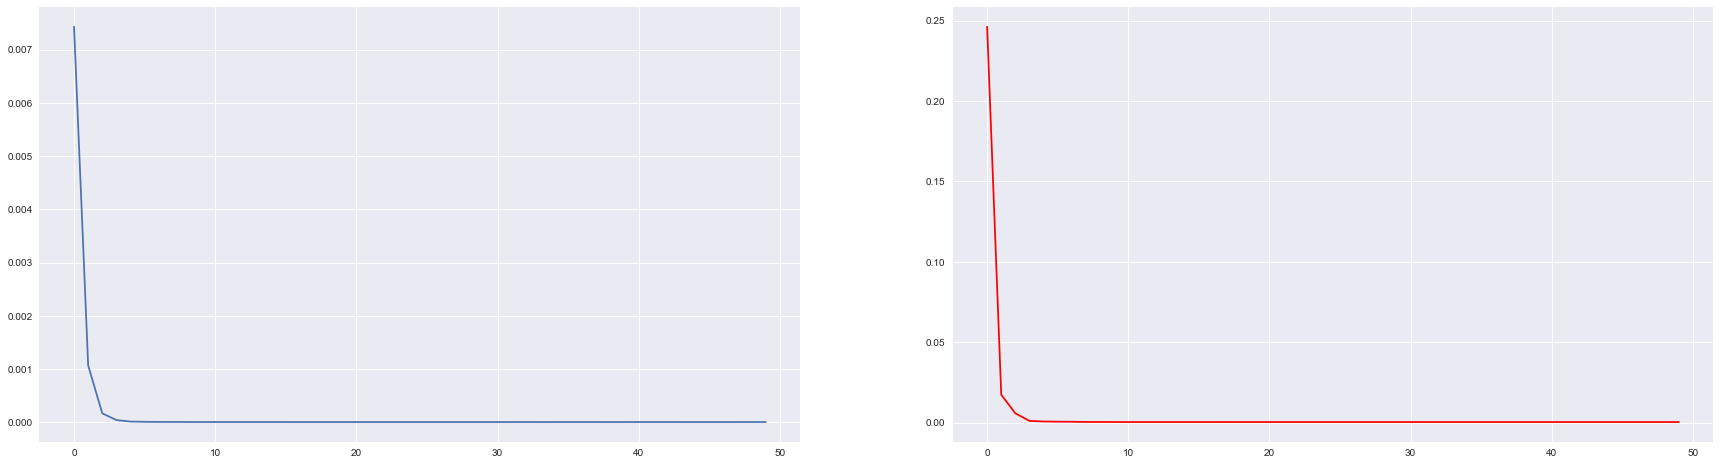

In [211]:
fig, axs = plt.subplots(1,2,figsize=(30,8))
axs[0].plot(np.arange(NUM_EPOCHS), losses)
axs[1].plot(np.arange(NUM_EPOCHS), val_losses, color='red')
plt.show()

### Проверка того что получилось

In [200]:
def get_mse_delta(y_true: torch.Tensor, y_net: torch.Tensor) -> float:
    loss = torch.nn.MSELoss()
    delta = loss(y_true, y_net).item()
    return delta

def get_max_error(y_true: Union[list, np.ndarray], y_net: Union[list, np.ndarray]) -> float:
    a = np.abs((np.array(y_true)-np.array(y_net))/(np.array(y_true)+ 1e-8)*100)
    return np.max(a)

def basic_func_check(model, sig_len, basics=6, sin_periods = 6):
    x = np.arange(sig_len)
    b0 = 2*np.sin(x*sin_periods/sig_len*2*np.pi)
    b1 = 20*np.sin(x*sin_periods/sig_len*2*np.pi)
    b2 = 2*np.ones((sig_len))
    b3 = 5*np.sqrt(x/10)
    b4 = np.arange(sig_len)/4
    b5 = 10+np.arange(sig_len)/2
    
    
    fig, axs = plt.subplots(basics,1,figsize=(14,8*basics))
    
    for i in range(basics):
#         exec("global old_string; old_string = new_string")
        exec(f'global base; base = b{i}')
        col_arr = np.array(list(base), dtype=np.float64)
        x_mean = np.mean(col_arr, axis=0)
        x_var = np.var(col_arr, axis=0)
        col_arr -= x_mean
        if x_var:
            col_arr /= x_var
        else:
            col_arr *= 0
        X_norm = col_arr
        
        out_normalized = net_1param(torch.Tensor(X_norm)).detach().numpy()
        out = out_normalized * x_var
        out += x_mean
        
        axs[i].plot(x, base, color = 'black', label='Изначальный сигнал')
        axs[i].plot(x, out, color = 'red', label='Сгенерированный сигнал')
        axs[i].legend()
        delta = get_mse_delta(torch.Tensor(base),torch.Tensor(out))
        max_error = get_max_error(base, out)
        axs[i].set(title=f"MSE: {np.round(delta,4)}\nMax error: {np.round(max_error,2)}%")
    
    plt.show()
    
def tensor_check(model, tensor, number_of_samples, mean, var, random_state=42, without_unnorm=False):
    origin_normalized = tensor.detach().numpy()
    N = number_of_samples
    samples_idxs = np.random.randint(0, len(tensor),size=N)
    fig, axs = plt.subplots(N,1,figsize=(14,8*N))
    x = np.arange(len(origin_normalized[0]))
    if without_unnorm:
        for i in range(N):
            idx = samples_idxs[i]
            out_normalized = net_1param(tensor[idx]).detach().numpy()
            axs[i].plot(x, origin_normalized[idx], color = 'black', label='Изначальный сигнал,\nнормализованный')
            axs[i].plot(x, out_normalized, color = 'red', label='Сгенерированный сигнал,\nнормализованный')
            axs[i].legend()
    
    else:
        origin = origin_normalized * var
        origin += mean
        
        for i in range(N):
            idx = samples_idxs[i]
            out_normalized = net_1param(tensor[idx]).detach().numpy()
            out = out_normalized * var
            out += mean
            axs[i].plot(x, origin[idx], color = 'black', label='Изначальный сигнал')
            axs[i].plot(x, out, color = 'red', label='Сгенерированный сигнал')
            axs[i].legend()
            delta = get_mse_delta(torch.Tensor(origin[idx]),torch.Tensor(out))
            max_error = get_max_error(origin[idx], out)
            axs[i].set(title=f"number of sample: {idx}\nMSE: {np.round(delta,4)}\nMax error: {int(max_error+0.5)}%")
        
    plt.show()

### Тест базовых сигналов

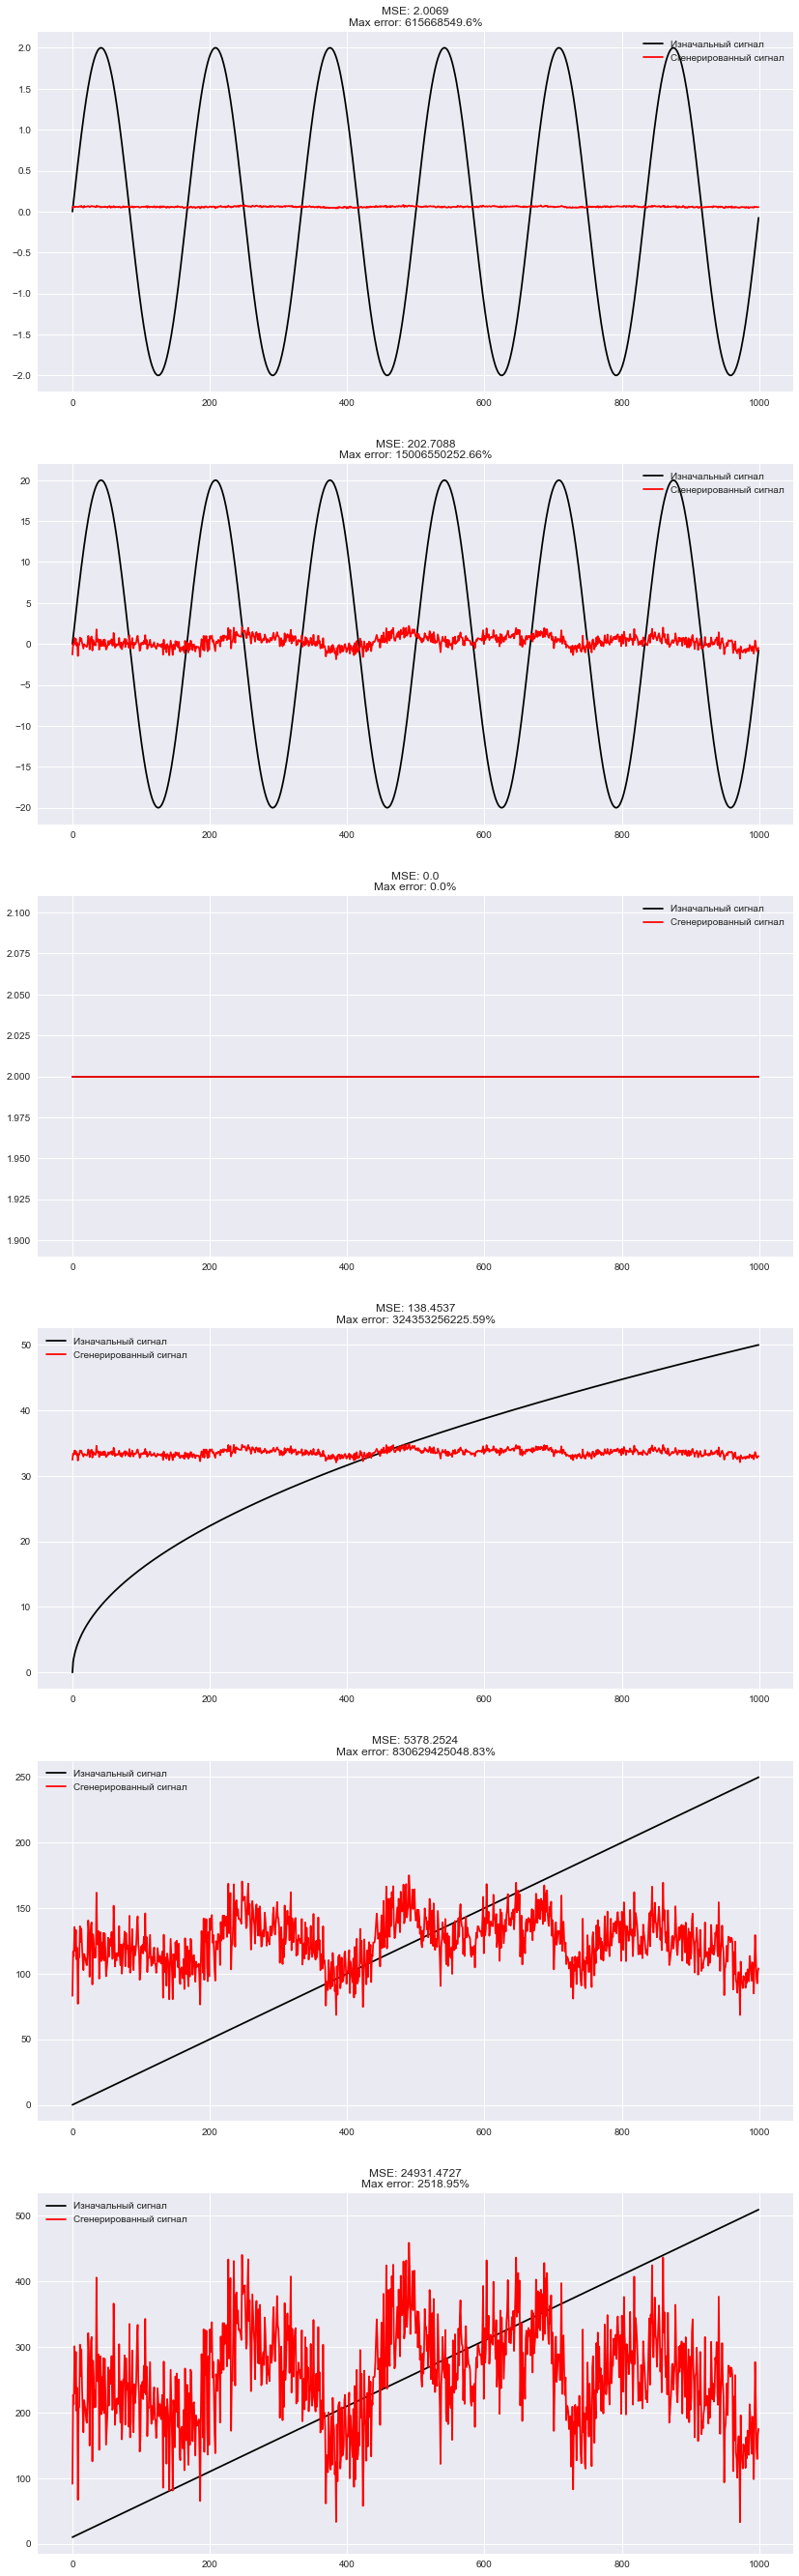

In [212]:
basic_func_check(net_1param, CUT_LEN)

### Тест на обучающей выборке

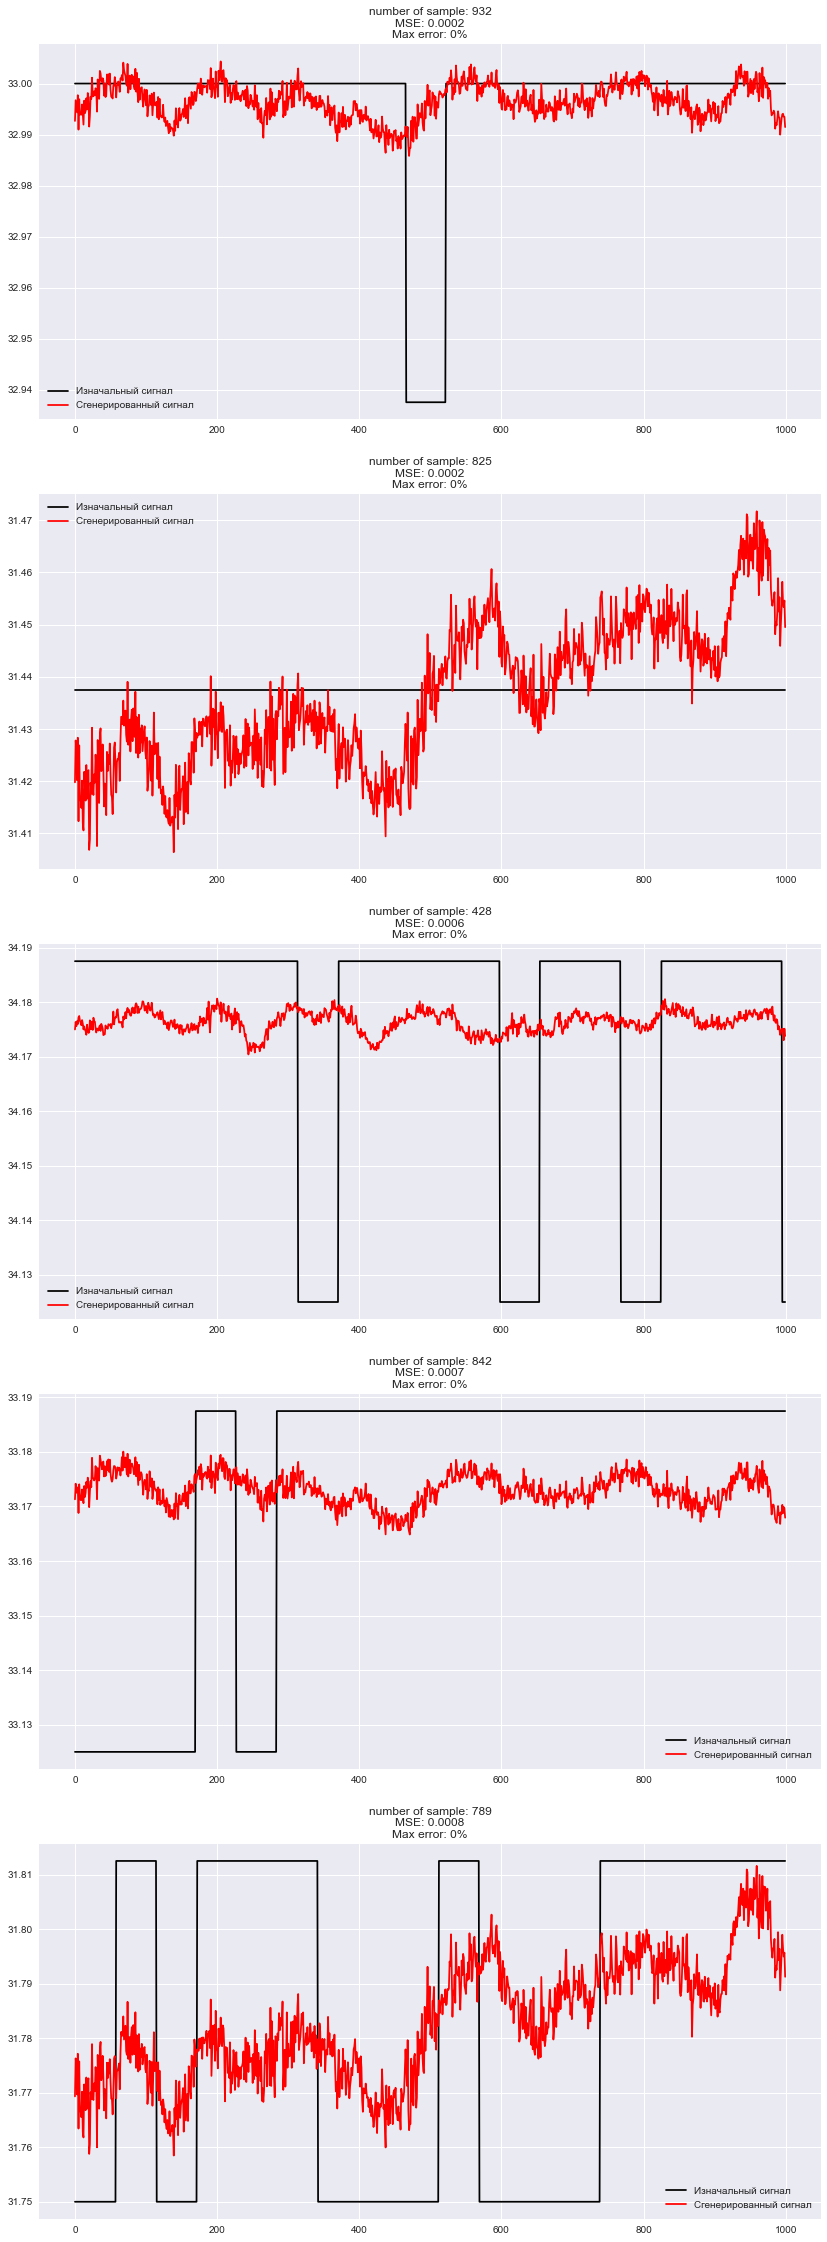

In [213]:
N = 5
tensor_check(net_1param, X_train_tensor, N, x_mean, x_var, without_unnorm=False)

### Тест на валидационной выборке

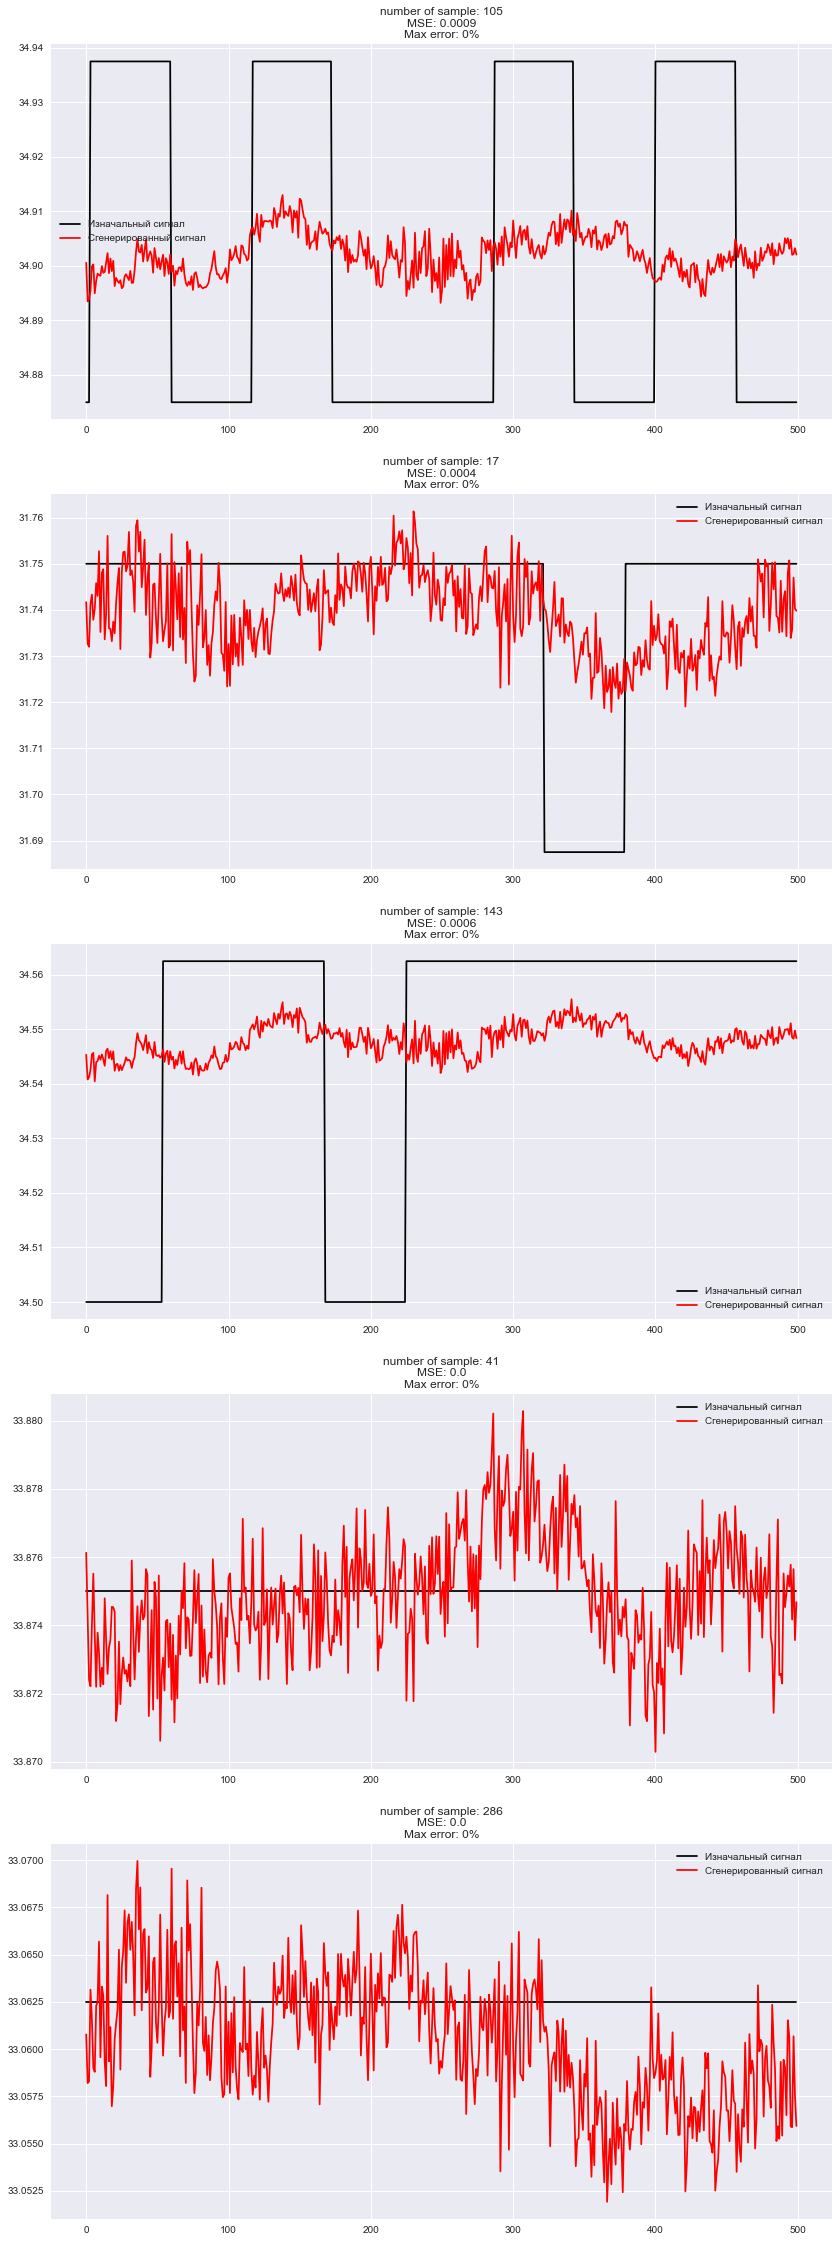

In [203]:
N = 5
tensor_check(net_1param, X_val_tensor, N, x_mean, x_var, without_unnorm=False)